In [1]:
# to access functions from root directory
import sys
sys.path.append('/data/ad181/RemoteDir/ada_multigrid_ppo')

In [2]:
%matplotlib notebook
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt 
from copy import deepcopy
from tqdm.notebook import trange, tqdm
import time

from utils.multigrid_framework_functions import generate_beta_environement
from utils.env_evaluate_functions import eval_actions

import matplotlib
matplotlib.rcParams['text.usetex'] = True

/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/co

In [3]:
case_label='case_2'
data_dir = './'+case_label
os.makedirs(data_dir, exist_ok=True)

# generate and gather multigrid environement data

In [4]:
with open('../envs_params/env_data/env_train.pkl', 'rb') as input:
    env = pickle.load(input)
m2_md_conv = 1.01325e+15

actions_ = np.ones((env.terminal_step,env.action_space.shape[0]))
seeds = [1]
betas = [0.25,0.5,1.0]
titles = [r'$\beta=0.25$',r'$\beta=0.5$',r'$\beta=1.0$']
rs = []
ks = []
ss = []
for seed in seeds:
    rs_seed = []
    ks_seed = []
    ss_seed = []
    for beta in betas:
        env_ = deepcopy(env)
        env_beta = generate_beta_environement(env_, beta,  env_.p_x, env_.p_y, seed )
        states, actions, rewards = eval_actions(env_beta, actions_)
        rs_seed.append(rewards)
        ks_seed.append( np.log(m2_md_conv*env_beta.k) )
        ss_seed.append(states)
    rs.append(rs_seed)
    ks.append(ks_seed)
    ss.append(ss_seed)

# compare permeability plots

<IPython.core.display.Javascript object>


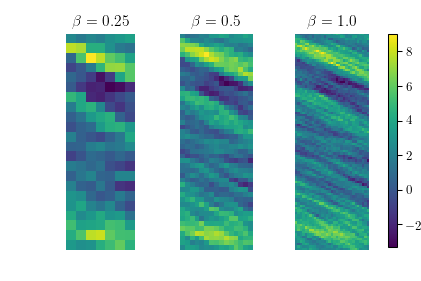

In [5]:
for seed in seeds:
    fig, axs = plt.subplots(1,len(betas),figsize=(1.5*len(betas),3) )
    for i,ax in enumerate(axs):
        ax.axis('off')
        im = ax.imshow(ks[seed-1][i], origin='lower')
        ax.set_title(titles[i])
    cbar_ax = fig.add_axes([0.92, 0.12, 0.02, 0.76])
    fig.colorbar(im, cax=cbar_ax, orientation="vertical") 
    fig.savefig(data_dir+'/'+case_label+'_k_mg.pdf')

# compare saturations plots

<IPython.core.display.Javascript object>


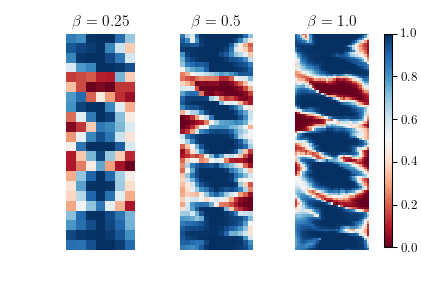

In [6]:
for seed in seeds:
    fig, axs = plt.subplots(1,len(betas),figsize=(1.5*len(betas),3) )
    for i,ax in enumerate(axs):
        ax.axis('off')
        im = ax.imshow(ss[seed-1][i][-1].reshape(( int(env.grid.ny*betas[i]) , int(env.grid.nx*betas[i]))) , origin='lower', cmap='RdBu', vmin=0, vmax=1)
        ax.set_title(titles[i])
    cbar_ax = fig.add_axes([0.91, 0.12, 0.02, 0.76])
    fig.colorbar(im, cax=cbar_ax, orientation="vertical") 
    fig.savefig(data_dir+'/'+case_label+'_s_mg.pdf')

# compare simulation time

In [7]:
ts,rs=[],[]
n_trials = 100
for seed in trange(n_trials):
    env.seed(seed)
    ts_seed, rs_seed = [], []
    for beta in betas:
        env_ = deepcopy(env)
        env_wrapped = generate_beta_environement(env_, beta,  env_.p_x, env_.p_y, seed )
        start_time = time.time()
        states, actions, rewards = eval_actions(env_wrapped, actions_)
        t = time.time() - start_time
        ts_seed.append(t)
        rs_seed.append(np.sum(rewards))
    ts.append(ts_seed)
    rs.append(rs_seed)

<IPython.core.display.Javascript object>


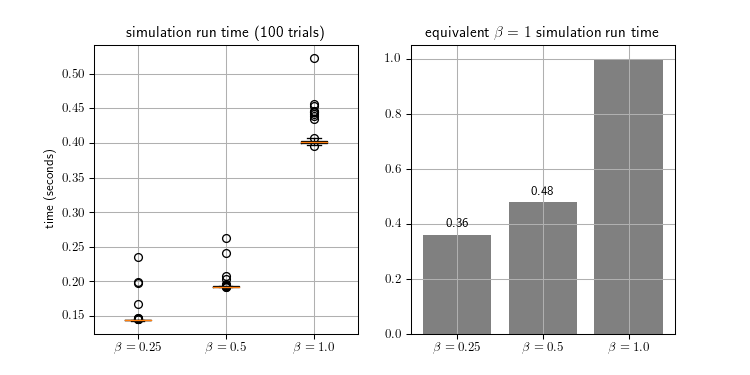

[0.36 0.48 1.  ]


In [8]:
ts = np.array(ts)
fig,axs = plt.subplots(1,2,figsize=(8,4))
axs[0].boxplot(ts)
axs[0].set_xticklabels(titles)
axs[0].grid('on')
axs[0].set_ylabel('time (seconds)')
axs[0].set_title('simulation run time ('+str(n_trials)+' trials)')

avg_t = ts.mean(axis=0)
avg_t = avg_t/avg_t[2]
print(np.around(avg_t,2))
axs[1].bar(titles, avg_t, color='gray', width=0.8 )
axs[1].grid('on')
axs[1].set_title(r'equivalent $\beta=1$ simulation run time')
for i,t in enumerate(avg_t[:2]):
    axs[1].text(i,t+0.04,str(round(t,2)),
            horizontalalignment='center',
            verticalalignment='center')
fig.savefig(data_dir+'/'+case_label+'_mg_time.pdf')

<IPython.core.display.Javascript object>


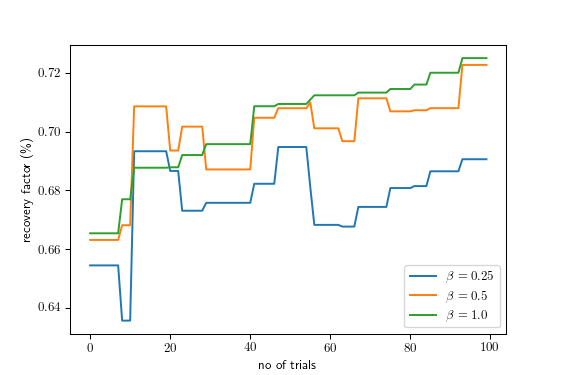

In [9]:
rs=np.array(rs)
fig,axs = plt.subplots(1,1,figsize=(6,4))
order = np.argsort(rs[:,2])
for i in range(3):
    axs.plot(rs[order,i])
axs.legend(titles)
axs.set_xlabel('no of trials')
axs.set_ylabel('recovery factor (\%)')
fig.show()